## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
import tensorflow
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = tensorflow.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.np_utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], regulizer=l1, ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=regulizer(ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=regulizer(ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [18]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 5
BATCH_SIZE = 32
MOMENTUM = 0.95
regulizer_ratio = [1e-4, 1e-8, 1e-12]
regulizers = [l1, l2, l1_l2]

In [19]:
results = {}
for regulizer in regulizers:
    for ratio in regulizer_ratio:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print(f"Experiment with Regulizer = {regulizer} and  Regulizer_ratio = {ratio:.6f}")
        model = build_mlp(input_shape=x_train.shape[1:], regulizer=regulizer, ratio=ratio)
        model.summary()
        optimizer = tensorflow.keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                epochs=EPOCHS, 
                batch_size=BATCH_SIZE, 
                validation_data=(x_test, y_test), 
                shuffle=True)
        
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]
        
        exp_name_tag = (f"Regulizer = {regulizer}, Regularizer ratio: {ratio}")
        results[exp_name_tag] = {'train-loss': train_loss,
                                'valid-loss': valid_loss,
                                'train-acc': train_acc,
                                'valid-acc': valid_acc}

Experiment with Regulizer = <class 'keras.regularizers.L1'> and  Regulizer_ratio = 0.000100
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896     
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________

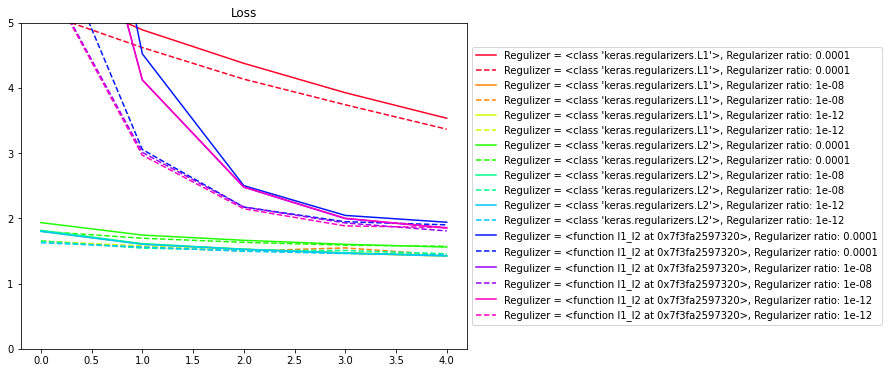

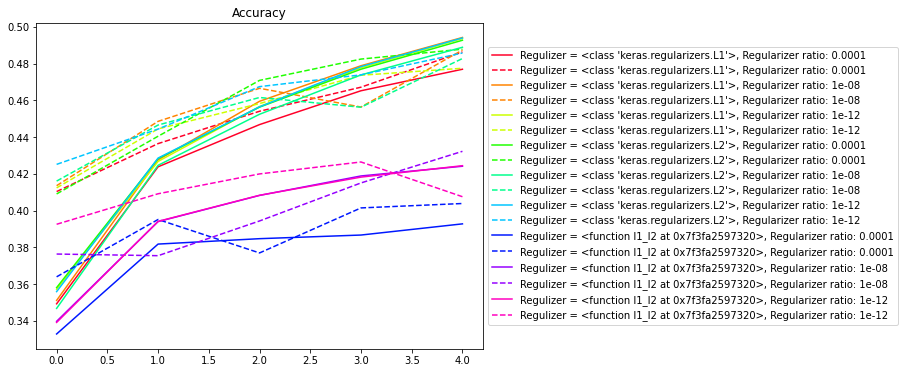

In [24]:
from matplotlib import cm as mplcm
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

NUM_COLORS = 9

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [21]:
results.keys()

dict_keys(["Regulizer = <class 'keras.regularizers.L1'>, Regularizer ratio: 0.0001", "Regulizer = <class 'keras.regularizers.L1'>, Regularizer ratio: 1e-08", "Regulizer = <class 'keras.regularizers.L1'>, Regularizer ratio: 1e-12", "Regulizer = <class 'keras.regularizers.L2'>, Regularizer ratio: 0.0001", "Regulizer = <class 'keras.regularizers.L2'>, Regularizer ratio: 1e-08", "Regulizer = <class 'keras.regularizers.L2'>, Regularizer ratio: 1e-12", 'Regulizer = <function l1_l2 at 0x7f3fa2597320>, Regularizer ratio: 0.0001', 'Regulizer = <function l1_l2 at 0x7f3fa2597320>, Regularizer ratio: 1e-08', 'Regulizer = <function l1_l2 at 0x7f3fa2597320>, Regularizer ratio: 1e-12'])